# Loading Library and Dataset

In [1]:
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
import seaborn
%matplotlib inline
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
thefile = "Kevin_Hillstrom.csv"
df = pd.read_csv(thefile)

# Prepocessing Data

In [3]:
df.shape

(64000, 12)

In [4]:
df.head()

,recency,history_segment,history,mens,womens,zip_code,newbie,channel,segment,visit,conversion,spend
0,10,2) $100 - $200,142.44,1,0,Surburban,0,Phone,Womens E-Mail,0,0,0.0
1,6,3) $200 - $350,329.08,1,1,Rural,1,Web,No E-Mail,0,0,0.0
2,7,2) $100 - $200,180.65,0,1,Surburban,1,Web,Womens E-Mail,0,0,0.0
3,9,5) $500 - $750,675.83,1,0,Rural,1,Web,Mens E-Mail,0,0,0.0
4,2,1) $0 - $100,45.34,1,0,Urban,0,Web,Womens E-Mail,0,0,0.0


In [5]:
df.conversion.value_counts()

0    63422
1      578
Name: conversion, dtype: int64

In [6]:
df.segment.value_counts()

Womens E-Mail    21387
Mens E-Mail      21307
No E-Mail        21306
Name: segment, dtype: int64

In [7]:
df.channel.value_counts()

Web             28217
Phone           28021
Multichannel     7762
Name: channel, dtype: int64

In [8]:
df.zip_code.value_counts()

Surburban    28776
Urban        25661
Rural         9563
Name: zip_code, dtype: int64

In [9]:
df.history_segment = df.history_segment.str[0]
df = pd.concat([df,pd.get_dummies(df.history_segment, prefix='history_segment')],axis=1)

In [10]:
# dummify

feat = ['zip_code','channel']
features = []
for f in feat : 
    dummies = pd.get_dummies(df[f]).rename(columns=lambda x: f + "_" + str(x))
    features = features + list(dummies.columns)
    df = pd.concat([df, dummies], axis=1)
    df = df.drop([f], axis=1)
    print("done", f)

done zip_code
done channel


In [11]:
df['istarget'] = df['segment'].map(lambda x : 0 if x=='No E-Mail' else 1)

In [12]:
df=df.drop(['history_segment','segment','history'],axis=1)
df.head()

,recency,mens,womens,newbie,visit,conversion,spend,history_segment_1,history_segment_2,history_segment_3,...,history_segment_5,history_segment_6,history_segment_7,zip_code_Rural,zip_code_Surburban,zip_code_Urban,channel_Multichannel,channel_Phone,channel_Web,istarget
0,10,1,0,0,0,0,0.0,0,1,0,...,0,0,0,0,1,0,0,1,0,1
1,6,1,1,1,0,0,0.0,0,0,1,...,0,0,0,1,0,0,0,0,1,0
2,7,0,1,1,0,0,0.0,0,1,0,...,0,0,0,0,1,0,0,0,1,1
3,9,1,0,1,0,0,0.0,0,0,0,...,1,0,0,1,0,0,0,0,1,1
4,2,1,0,0,0,0,0.0,1,0,0,...,0,0,0,0,0,1,0,0,1,1


# Splitting Data

In [13]:
features = df.columns.drop(['conversion','spend'])
x_calls = features.drop(['istarget'])

In [14]:
from sklearn import model_selection
train_df,test_df= model_selection.train_test_split(df,test_size=0.33, stratify = df.conversion,random_state=217)

In [15]:
print(train_df.groupby('conversion').size())
print(test_df.groupby('conversion').size())

conversion
0    42493
1      387
dtype: int64
conversion
0    20929
1      191
dtype: int64


In [16]:
print(train_df.groupby(['istarget','conversion']).size())
print(test_df.groupby(['istarget','conversion']).size())

istarget  conversion
0         0             14245
          1                75
1         0             28248
          1               312
dtype: int64
istarget  conversion
0         0              6939
          1                47
1         0             13990
          1               144
dtype: int64


# Choosing Model

In [17]:
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
from sklearn.metrics import roc_auc_score,roc_auc_score,f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import GradientBoostingClassifier,RandomForestClassifier,AdaBoostClassifier,ExtraTreesClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from multiscorer import MultiScorer

In [18]:
# Spot all methods want to be used
models = []
models.append(('LR', LogisticRegression()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
models.append(('GBM', LGBMClassifier()))
models.append(('GBC', GradientBoostingClassifier()))
models.append(('XGBC', XGBClassifier()))
models.append(('ADB', AdaBoostClassifier()))
models.append(('RFC', RandomForestClassifier()))
models.append(('ETC', ExtraTreesClassifier()))

for name, model in models:
    # Spot all scorers want to be used
    scorer = MultiScorer({'Accuracy' : (accuracy_score,  {}),\
            'ROC_AUC'  : (roc_auc_score,{'average' : 'weighted'}),\
            'F-measure': (f1_score,{'average' : 'weighted'})})
        
    # Cross Validation Model
    kfold = model_selection.StratifiedKFold(n_splits=10, random_state=7)
    model_selection.cross_val_score(model,train_df[train_df.istarget==0][x_calls], train_df[train_df.istarget==0]['conversion'],
                                cv=kfold, scoring=scorer,fit_params={'sample_weight':[75 if y==0 else 14275 for y in
                                train_df[train_df.istarget==0]['conversion']]})
    scoring = scorer.get_results()
    cv_results1 = scoring['Accuracy']
    cv_results2 = scoring['ROC_AUC']
    cv_results3 = scoring['F-measure']
    msg = "%s by Accuracy: %f(%f), by ROC_AUC: %f(%f), and by F1 Score: %f(%f)" % (name, np.average(cv_results1),
            np.std(cv_results1), np.average(cv_results2), np.std(cv_results2), np.average(cv_results3),np.std(cv_results3))
    print(msg)

LR by Accuracy: 0.903283(0.007852), by ROC_AUC: 0.951387(0.003951), and by F1 Score: 0.944431(0.004463)
CART by Accuracy: 0.987431(0.002455), by ROC_AUC: 0.528282(0.041861), and by F1 Score: 0.988707(0.001281)
NB by Accuracy: 0.903283(0.007852), by ROC_AUC: 0.951387(0.003951), and by F1 Score: 0.944431(0.004463)
GBM by Accuracy: 0.977725(0.005081), by ROC_AUC: 0.550049(0.042077), and by F1 Score: 0.983794(0.002596)
GBC by Accuracy: 0.922208(0.009280), by ROC_AUC: 0.867640(0.059211), and by F1 Score: 0.954821(0.005141)
XGBC by Accuracy: 0.915993(0.008444), by ROC_AUC: 0.905377(0.070121), and by F1 Score: 0.951443(0.004716)
ADB by Accuracy: 0.903283(0.007852), by ROC_AUC: 0.951387(0.003951), and by F1 Score: 0.944431(0.004463)
RFC by Accuracy: 0.990992(0.001445), by ROC_AUC: 0.523857(0.042195), and by F1 Score: 0.990537(0.000949)
ETC by Accuracy: 0.989316(0.001923), by ROC_AUC: 0.536337(0.042347), and by F1 Score: 0.989772(0.001146)


In [19]:
# Spot all methods want to be used
models = []
models.append(('LR', LogisticRegression()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
models.append(('GBM', LGBMClassifier()))
models.append(('GBC', GradientBoostingClassifier()))
models.append(('XGBC', XGBClassifier()))
models.append(('ADB', AdaBoostClassifier()))
models.append(('RFC', RandomForestClassifier()))
models.append(('ETC', ExtraTreesClassifier()))

for name, model in models:
    # Spot all scorers want to be used
    scorer = MultiScorer({'Accuracy' : (accuracy_score,  {}),\
            'ROC_AUC'  : (roc_auc_score,{'average' : 'weighted'}),\
            'F-measure': (f1_score,{'average' : 'weighted'})})
        
    # Cross Validation Model
    kfold = model_selection.StratifiedKFold(n_splits=10, random_state=7)
    model_selection.cross_val_score(model,train_df[train_df.istarget==1][x_calls], train_df[train_df.istarget==1]['conversion'],
                                cv=kfold, scoring=scorer,fit_params={'sample_weight':[312 if y==0 else 28248 for y in
                                train_df[train_df.istarget==1]['conversion']]})
    scoring = scorer.get_results()
    cv_results1 = scoring['Accuracy']
    cv_results2 = scoring['ROC_AUC']
    cv_results3 = scoring['F-measure']
    msg = "%s by Accuracy: %f(%f), by ROC_AUC: %f(%f), and by F1 Score: %f(%f)" % (name, np.average(cv_results1),
            np.std(cv_results1), np.average(cv_results2), np.std(cv_results2), np.average(cv_results3),np.std(cv_results3))
    print(msg)

LR by Accuracy: 0.843767(0.007955), by ROC_AUC: 0.921021(0.004016), and by F1 Score: 0.905584(0.004683)
CART by Accuracy: 0.958088(0.003803), by ROC_AUC: 0.598585(0.052886), and by F1 Score: 0.969008(0.002213)
NB by Accuracy: 0.843767(0.007955), by ROC_AUC: 0.921021(0.004016), and by F1 Score: 0.905584(0.004683)
GBM by Accuracy: 0.907457(0.005106), by ROC_AUC: 0.731250(0.068860), and by F1 Score: 0.942034(0.002861)
GBC by Accuracy: 0.847408(0.007978), by ROC_AUC: 0.908555(0.015937), and by F1 Score: 0.907748(0.004672)
XGBC by Accuracy: 0.846533(0.008276), by ROC_AUC: 0.919279(0.006263), and by F1 Score: 0.907230(0.004853)
ADB by Accuracy: 0.843767(0.007955), by ROC_AUC: 0.921021(0.004016), and by F1 Score: 0.905584(0.004683)
RFC by Accuracy: 0.967052(0.003482), by ROC_AUC: 0.579440(0.046840), and by F1 Score: 0.973652(0.002213)
ETC by Accuracy: 0.958824(0.003935), by ROC_AUC: 0.594221(0.046746), and by F1 Score: 0.969362(0.002201)


In this moment, we don't tune the parameters of all models. Therefore, we decided four best model according to the AUC score.

# Evaluating Model

In [20]:
def evaluate_model(name,model,X_train, X_validation, Y_train, Y_validation, weights):
    print(name)
    model.fit(X_train, Y_train,sample_weight=weights)
    predictions = model.predict(X_validation)
    print("Accuracy Score: %f" % accuracy_score(Y_validation, predictions))
    auc=roc_auc_score(Y_validation, predictions)
    print("AUC: %f" % auc)
    print(confusion_matrix(Y_validation, predictions))
    print(classification_report(Y_validation, predictions))
    return(model)

In [21]:
model_control_1=evaluate_model('LR',LogisticRegression(),train_df[train_df.istarget==0][x_calls],\
                             test_df[test_df.istarget==0][x_calls],train_df[train_df.istarget==0]['conversion'],\
                             test_df[test_df.istarget==0]['conversion'],[75 if y==0 else 14275 for y in
                                train_df[train_df.istarget==0]['conversion']])

LR
Accuracy Score: 0.904810
AUC: 0.920384
[[6277  662]
 [   3   44]]
              precision    recall  f1-score   support

           0       1.00      0.90      0.95      6939
           1       0.06      0.94      0.12        47

   micro avg       0.90      0.90      0.90      6986
   macro avg       0.53      0.92      0.53      6986
weighted avg       0.99      0.90      0.94      6986



In [22]:
model_control_2=evaluate_model('GNB',GaussianNB(),train_df[train_df.istarget==0][x_calls],\
                             test_df[test_df.istarget==0][x_calls],train_df[train_df.istarget==0]['conversion'],\
                             test_df[test_df.istarget==0]['conversion'],[75 if y==0 else 14275 for y in
                                train_df[train_df.istarget==0]['conversion']])

GNB
Accuracy Score: 0.904810
AUC: 0.920384
[[6277  662]
 [   3   44]]
              precision    recall  f1-score   support

           0       1.00      0.90      0.95      6939
           1       0.06      0.94      0.12        47

   micro avg       0.90      0.90      0.90      6986
   macro avg       0.53      0.92      0.53      6986
weighted avg       0.99      0.90      0.94      6986



In [23]:
model_control_3=evaluate_model('XGBC',XGBClassifier(),train_df[train_df.istarget==0][x_calls],\
                             test_df[test_df.istarget==0][x_calls],train_df[train_df.istarget==0]['conversion'],\
                             test_df[test_df.istarget==0]['conversion'],[75 if y==0 else 14275 for y in
                                train_df[train_df.istarget==0]['conversion']])

XGBC
Accuracy Score: 0.916261
AUC: 0.873317
[[6362  577]
 [   8   39]]
              precision    recall  f1-score   support

           0       1.00      0.92      0.96      6939
           1       0.06      0.83      0.12        47

   micro avg       0.92      0.92      0.92      6986
   macro avg       0.53      0.87      0.54      6986
weighted avg       0.99      0.92      0.95      6986



In [24]:
model_control_4=evaluate_model('ADA',AdaBoostClassifier(),train_df[train_df.istarget==0][x_calls],\
                             test_df[test_df.istarget==0][x_calls],train_df[train_df.istarget==0]['conversion'],\
                             test_df[test_df.istarget==0]['conversion'],[75 if y==0 else 14275 for y in
                                train_df[train_df.istarget==0]['conversion']])

ADA
Accuracy Score: 0.904810
AUC: 0.920384
[[6277  662]
 [   3   44]]
              precision    recall  f1-score   support

           0       1.00      0.90      0.95      6939
           1       0.06      0.94      0.12        47

   micro avg       0.90      0.90      0.90      6986
   macro avg       0.53      0.92      0.53      6986
weighted avg       0.99      0.90      0.94      6986



In [25]:
model_target_1=evaluate_model('LR',LogisticRegression(),train_df[train_df.istarget==1][x_calls],\
                             test_df[test_df.istarget==1][x_calls],train_df[train_df.istarget==1]['conversion'],\
                             test_df[test_df.istarget==1]['conversion'],[312 if y==0 else 28248 for y in
                                train_df[train_df.istarget==1]['conversion']])

LR
Accuracy Score: 0.843356
AUC: 0.920872
[[11776  2214]
 [    0   144]]
              precision    recall  f1-score   support

           0       1.00      0.84      0.91     13990
           1       0.06      1.00      0.12       144

   micro avg       0.84      0.84      0.84     14134
   macro avg       0.53      0.92      0.51     14134
weighted avg       0.99      0.84      0.91     14134



In [26]:
model_target_2=evaluate_model('GNB',GaussianNB(),train_df[train_df.istarget==1][x_calls],\
                             test_df[test_df.istarget==1][x_calls],train_df[train_df.istarget==1]['conversion'],\
                             test_df[test_df.istarget==1]['conversion'],[312 if y==0 else 28248 for y in
                                train_df[train_df.istarget==1]['conversion']])

GNB
Accuracy Score: 0.843356
AUC: 0.920872
[[11776  2214]
 [    0   144]]
              precision    recall  f1-score   support

           0       1.00      0.84      0.91     13990
           1       0.06      1.00      0.12       144

   micro avg       0.84      0.84      0.84     14134
   macro avg       0.53      0.92      0.51     14134
weighted avg       0.99      0.84      0.91     14134



In [27]:
model_target_3=evaluate_model('XGBC',XGBClassifier(),train_df[train_df.istarget==1][x_calls],\
                             test_df[test_df.istarget==1][x_calls],train_df[train_df.istarget==1]['conversion'],\
                             test_df[test_df.istarget==1]['conversion'],[312 if y==0 else 28248 for y in
                                train_df[train_df.istarget==1]['conversion']])

XGBC
Accuracy Score: 0.845267
AUC: 0.904655
[[11808  2182]
 [    5   139]]
              precision    recall  f1-score   support

           0       1.00      0.84      0.92     13990
           1       0.06      0.97      0.11       144

   micro avg       0.85      0.85      0.85     14134
   macro avg       0.53      0.90      0.51     14134
weighted avg       0.99      0.85      0.91     14134



In [28]:
model_target_4=evaluate_model('ADA',AdaBoostClassifier(),train_df[train_df.istarget==1][x_calls],\
                             test_df[test_df.istarget==1][x_calls],train_df[train_df.istarget==1]['conversion'],\
                             test_df[test_df.istarget==1]['conversion'],[312 if y==0 else 28248 for y in
                                train_df[train_df.istarget==1]['conversion']])

ADA
Accuracy Score: 0.843356
AUC: 0.920872
[[11776  2214]
 [    0   144]]
              precision    recall  f1-score   support

           0       1.00      0.84      0.91     13990
           1       0.06      1.00      0.12       144

   micro avg       0.84      0.84      0.84     14134
   macro avg       0.53      0.92      0.51     14134
weighted avg       0.99      0.84      0.91     14134



## Calculating the uplift

In [29]:
test_df["uplift_1"] = model_target_1.predict_proba(test_df[x_calls])[:,1] - model_control_1.predict_proba(test_df[x_calls])[:,1]

In [30]:
test_df["uplift_2"] = model_target_2.predict_proba(test_df[x_calls])[:,1] - model_control_2.predict_proba(test_df[x_calls])[:,1]

In [31]:
test_df["uplift_3"] = model_target_3.predict_proba(test_df[x_calls])[:,1] - model_control_3.predict_proba(test_df[x_calls])[:,1]

In [32]:
test_df["uplift_4"] = model_target_4.predict_proba(test_df[x_calls])[:,1] - model_control_4.predict_proba(test_df[x_calls])[:,1]

In [33]:
test_df.head()

,recency,mens,womens,newbie,visit,conversion,spend,history_segment_1,history_segment_2,history_segment_3,...,zip_code_Surburban,zip_code_Urban,channel_Multichannel,channel_Phone,channel_Web,istarget,uplift_1,uplift_2,uplift_3,uplift_4
27799,2,1,0,0,0,0,0.0,0,1,0,...,0,1,0,1,0,0,-0.000019,0.0,-0.000050,0.000614
25408,6,1,0,1,0,0,0.0,0,0,0,...,0,1,0,1,0,1,-0.000020,0.0,-0.000025,0.000083
816,1,0,1,1,0,0,0.0,0,1,0,...,0,0,0,1,0,1,-0.000013,0.0,0.000013,0.000712
54564,2,1,0,1,0,0,0.0,1,0,0,...,1,0,0,0,1,1,-0.000018,0.0,0.000062,0.000862
16499,5,1,0,1,0,0,0.0,0,1,0,...,1,0,0,0,1,0,-0.000007,0.0,-0.000032,0.001889


# Class Modification approach

In [34]:
train_df['modified_conversion'] = train_df['conversion'] * train_df['istarget'] \
                                 + (1-train_df['conversion'])*(1-train_df['istarget'])

In [35]:
test_df['modified_conversion'] = test_df['conversion'] * test_df['istarget'] \
                                 + (1-test_df['conversion'])*(1-test_df['istarget'])

In [36]:
train_df.head()

,recency,mens,womens,newbie,visit,conversion,spend,history_segment_1,history_segment_2,history_segment_3,...,history_segment_6,history_segment_7,zip_code_Rural,zip_code_Surburban,zip_code_Urban,channel_Multichannel,channel_Phone,channel_Web,istarget,modified_conversion
14537,3,0,1,1,0,0,0.0,0,1,0,...,0,0,0,1,0,0,1,0,1,0
34998,3,0,1,1,0,0,0.0,1,0,0,...,0,0,0,0,1,0,0,1,1,0
3178,3,1,1,0,1,0,0.0,0,0,1,...,0,0,0,1,0,0,0,1,1,0
6877,1,1,1,1,0,0,0.0,0,0,0,...,0,0,0,1,0,0,0,1,0,1
26948,10,0,1,0,0,0,0.0,0,0,1,...,0,0,0,1,0,0,1,0,0,1


In [37]:
train_df.groupby(['modified_conversion']).size()

modified_conversion
0    28323
1    14557
dtype: int64

In [38]:
# Spot all methods want to be used
models = []
models.append(('LR', LogisticRegression()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
models.append(('GBM', LGBMClassifier()))
models.append(('GBC', GradientBoostingClassifier()))
models.append(('XGBC', XGBClassifier()))
models.append(('ADB', AdaBoostClassifier()))
models.append(('RFC', RandomForestClassifier()))
models.append(('ETC', ExtraTreesClassifier()))

for name, model in models:
    # Spot all scorers want to be used
    scorer = MultiScorer({'Accuracy' : (accuracy_score,  {}),\
            'ROC_AUC'  : (roc_auc_score,{'average' : 'weighted'}),\
            'F-measure': (f1_score,{'average' : 'weighted'})})
        
    # Cross Validation Model
    kfold = model_selection.StratifiedKFold(n_splits=10, random_state=7)
    model_selection.cross_val_score(model,train_df[x_calls], train_df.modified_conversion,
                                cv=kfold, scoring=scorer,fit_params={'sample_weight':[14557 if y==0 else 28323 for y in
                                train_df.modified_conversion]})
    scoring = scorer.get_results()
    cv_results1 = scoring['Accuracy']
    cv_results2 = scoring['ROC_AUC']
    cv_results3 = scoring['F-measure']
    msg = "%s by Accuracy: %f(%f), by ROC_AUC: %f(%f), and by F1 Score: %f(%f)" % (name, np.average(cv_results1),
            np.std(cv_results1), np.average(cv_results2), np.std(cv_results2), np.average(cv_results3),np.std(cv_results3))
    print(msg)

LR by Accuracy: 0.447832(0.011262), by ROC_AUC: 0.516776(0.005402), and by F1 Score: 0.437158(0.017954)
CART by Accuracy: 0.511334(0.010417), by ROC_AUC: 0.507937(0.009548), and by F1 Score: 0.524195(0.010094)
NB by Accuracy: 0.420851(0.013885), by ROC_AUC: 0.517518(0.006691), and by F1 Score: 0.383578(0.025393)
GBM by Accuracy: 0.478358(0.008178), by ROC_AUC: 0.511522(0.005170), and by F1 Score: 0.486417(0.009741)
GBC by Accuracy: 0.471106(0.009843), by ROC_AUC: 0.514445(0.003866), and by F1 Score: 0.475335(0.013038)
XGBC by Accuracy: 0.470546(0.009635), by ROC_AUC: 0.514388(0.005474), and by F1 Score: 0.474641(0.012369)
ADB by Accuracy: 0.453849(0.009411), by ROC_AUC: 0.514486(0.004795), and by F1 Score: 0.448945(0.014248)
RFC by Accuracy: 0.518983(0.007187), by ROC_AUC: 0.508819(0.007272), and by F1 Score: 0.531244(0.006928)
ETC by Accuracy: 0.512710(0.010154), by ROC_AUC: 0.508861(0.009302), and by F1 Score: 0.525519(0.009831)


Without tuning parameters, we can see that the result is not good for using class modification. So, in this moment we don't use class modification for uplift modelling.

# Evaluating Uplift

## uplift distribution 

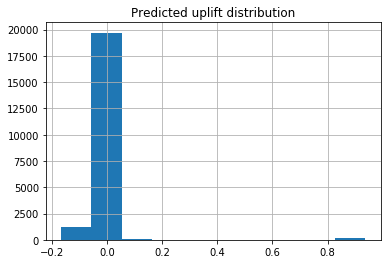

In [39]:
plt.title("Predicted uplift distribution")
test_df["uplift_1"].hist()

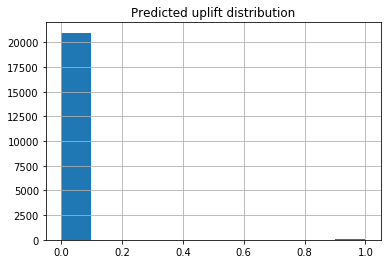

In [40]:
plt.title("Predicted uplift distribution")
test_df["uplift_2"].hist()

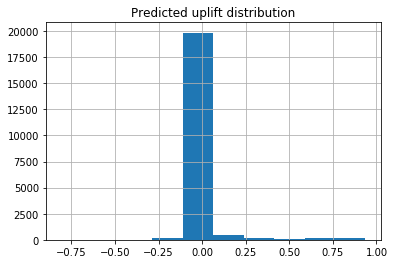

In [41]:
plt.title("Predicted uplift distribution")
test_df["uplift_3"].hist()

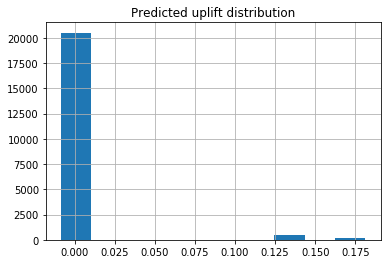

In [42]:
plt.title("Predicted uplift distribution")
test_df["uplift_4"].hist()

In [43]:
test_df['perfect'] = test_df['conversion'] * test_df['istarget'] -  test_df['conversion'] * (1-test_df['istarget'])

## Evaluating uplift using Library evaluating_uplift

In [44]:
from evaluating_uplift import Uplift

In [45]:
uplift_1 = Uplift(test_df,"istarget","conversion", "uplift_1")
uplift_2 = Uplift(test_df,"istarget","conversion", "uplift_2")
uplift_3 = Uplift(test_df,"istarget","conversion", "uplift_3")
uplift_4 = Uplift(test_df,"istarget","conversion", "uplift_4")
perfect = Uplift(test_df,"istarget","conversion", "perfect")

### Costumer uplift

In this part, we separate costumers to be ten class according to the uplift. The bar below, show us the percentage of costumers who conversion because of the campaign.

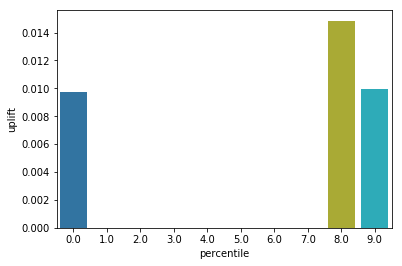

In [46]:
hist_twomod = uplift_1.get_hist()
ax = seaborn.barplot(hist_twomod["percentile"],hist_twomod['uplift'])

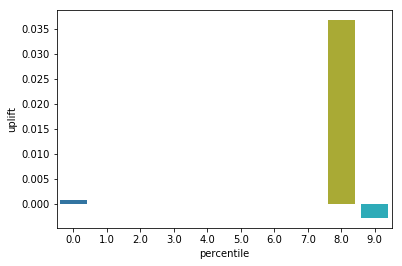

In [47]:
hist_twomod = uplift_2.get_hist()
ax = seaborn.barplot(hist_twomod["percentile"],hist_twomod['uplift'])

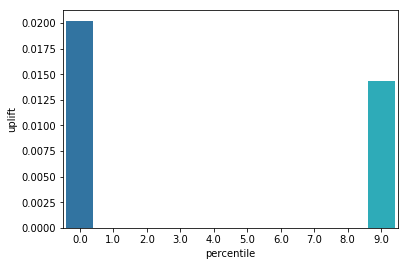

In [48]:
hist_twomod = uplift_3.get_hist()
ax = seaborn.barplot(hist_twomod["percentile"],hist_twomod['uplift'])

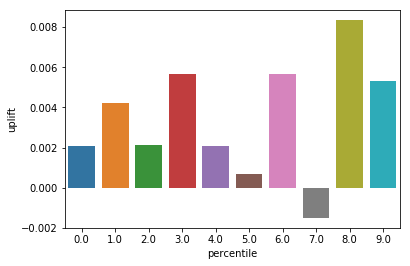

In [49]:
hist_twomod = uplift_4.get_hist()
ax = seaborn.barplot(hist_twomod["percentile"],hist_twomod['uplift'])

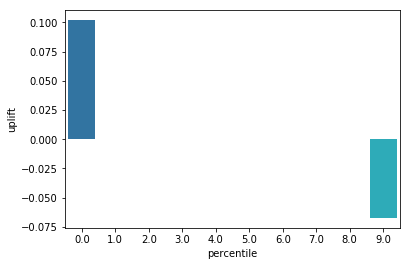

In [50]:
hist_twomod = perfect.get_hist()
ax = seaborn.barplot(hist_twomod["percentile"],hist_twomod['uplift'])

### Uplift Prediction versus Uplift Actual 

estimate of average error in predicting is 0.012


C:\Users\da_team\AppData\Roaming\Python\Python36\site-packages\seaborn\categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


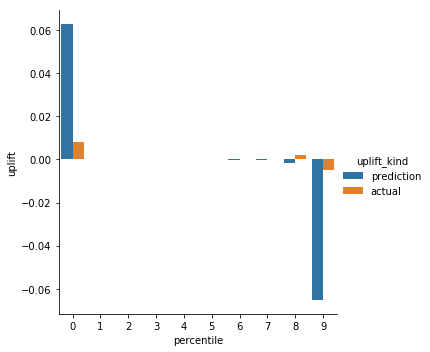

In [51]:
hist_twomod,eps = uplift_1.act_pred()
print('estimate of average error in predicting is {}'.format(round(eps,3)))
seaborn.factorplot(x='percentile', y='uplift', hue='uplift_kind', data=hist_twomod, kind='bar')

estimate of average error in predicting is 0.007


C:\Users\da_team\AppData\Roaming\Python\Python36\site-packages\seaborn\categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


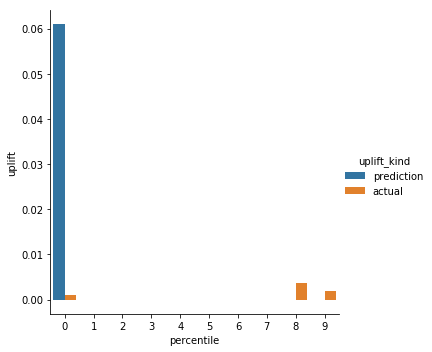

In [52]:
hist_twomod,eps = uplift_2.act_pred()
print('estimate of average error in predicting is {}'.format(round(eps,3)))
seaborn.factorplot(x='percentile', y='uplift', hue='uplift_kind', data=hist_twomod, kind='bar')

estimate of average error in predicting is 0.025


C:\Users\da_team\AppData\Roaming\Python\Python36\site-packages\seaborn\categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


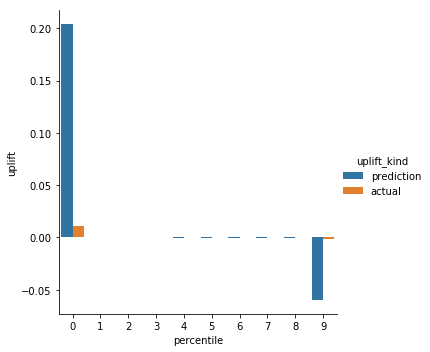

In [53]:
hist_twomod,eps = uplift_3.act_pred()
print('estimate of average error in predicting is {}'.format(round(eps,3)))
seaborn.factorplot(x='percentile', y='uplift', hue='uplift_kind', data=hist_twomod, kind='bar')

C:\Users\da_team\AppData\Roaming\Python\Python36\site-packages\seaborn\categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


estimate of average error in predicting is 0.008


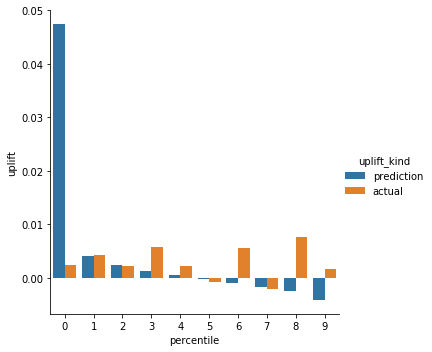

In [54]:
hist_twomod,eps = uplift_4.act_pred()
print('estimate of average error in predicting is {}'.format(round(eps,3)))
seaborn.factorplot(x='percentile', y='uplift', hue='uplift_kind', data=hist_twomod, kind='bar')

### The Cummulative of Uplift

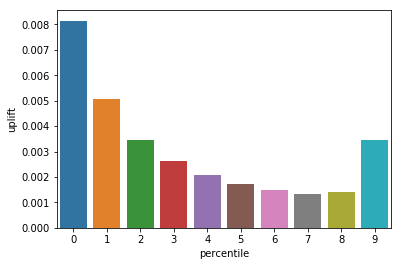

In [55]:
hist_twomod = uplift_1.get_hist_cum()
ax = seaborn.barplot(hist_twomod["percentile"],hist_twomod['uplift'])

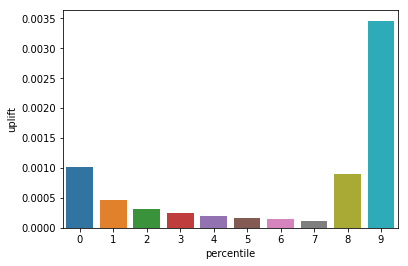

In [56]:
hist_twomod = uplift_2.get_hist_cum()
ax = seaborn.barplot(hist_twomod["percentile"],hist_twomod['uplift'])

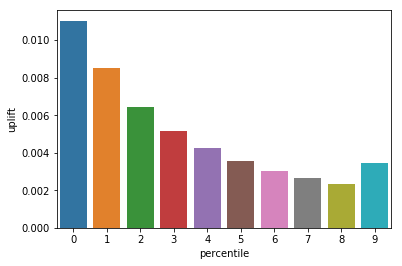

In [57]:
hist_twomod = uplift_3.get_hist_cum()
ax = seaborn.barplot(hist_twomod["percentile"],hist_twomod['uplift'])

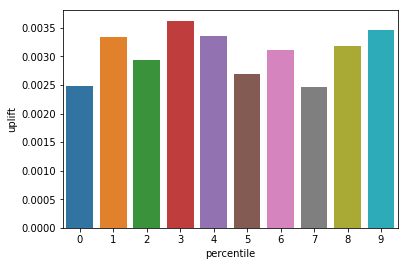

In [58]:
hist_twomod = uplift_4.get_hist_cum()
ax = seaborn.barplot(hist_twomod["percentile"],hist_twomod['uplift'])

## The Assesment of Uplift Model

# Using Number of Target vs Number of Conversion

In [59]:
perfect_gains = perfect.gains()
gains_1 = uplift_1.gains()
gains_2 = uplift_2.gains()
gains_3 = uplift_3.gains()
gains_4 = uplift_4.gains()

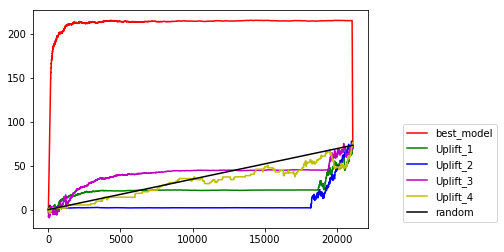

In [60]:
plot(perfect_gains.index,perfect_gains.RT, color = 'r', label = 'best_model')
plot(gains_1.index,gains_1.RT, color =  'g', label = 'Uplift_1')
plot(gains_2.index,gains_2.RT, color =  'b', label = 'Uplift_2')
plot(gains_3.index,gains_3.RT, color =  'm', label = 'Uplift_3')
plot(gains_4.index,gains_4.RT, color =  'y', label = 'Uplift_4')
plot(gains_1.index,gains_1.Random,color = 'k', label = 'random')
plt.legend(bbox_to_anchor=(1.4, 0.5))

## Using Qini Curve

In [61]:
perfect_qini = perfect.qini_curve()
qini_curve_1 = uplift_1.qini_curve()
qini_curve_2 = uplift_2.qini_curve()
qini_curve_3 = uplift_3.qini_curve()
qini_curve_4 = uplift_4.qini_curve()

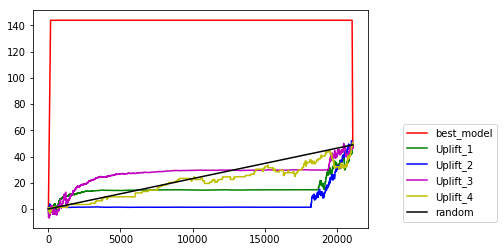

In [62]:
plot(perfect_qini.index,perfect_qini.RT, color = 'r', label = 'best_model')
plot(qini_curve_1.index,qini_curve_1.RT, color =  'g', label = 'Uplift_1')
plot(qini_curve_2.index,qini_curve_2.RT, color =  'b', label = 'Uplift_2')
plot(qini_curve_3.index,qini_curve_3.RT, color =  'm', label = 'Uplift_3')
plot(qini_curve_4.index,qini_curve_4.RT, color =  'y', label = 'Uplift_4')
plot(qini_curve_1.index,qini_curve_1.Random,color = 'k', label = 'random')
plt.legend(bbox_to_anchor=(1.4, 0.5))

By the both method above, we still cannot decide the best model. However, we know that the models still need high improvement.

## Using Qini Coefficient

In [63]:
print(uplift_1.qini_coef())
print(uplift_2.qini_coef())
print(uplift_3.qini_coef())
print(uplift_4.qini_coef())

-0.07540995976387027
-0.16683869103025586
0.021689865762337866
-0.034232718402213425


By Qini Coefficient we get model_3 is the best. Qini Coefficient is the common used method to asses the uplift model.

## Using Q_Athey

In [64]:
print(uplift_1.Q_Athey())
print(uplift_2.Q_Athey())
print(uplift_3.Q_Athey())
print(uplift_4.Q_Athey())

0.041860736771644314
0.04152592981664929
0.0471083785113039
0.03671888513663611


This method developed by Athey. The closer to the expected number (0.5), the better model.

Athey S, Imbens GW. 2015. Machine Learning Methods for Estimating Heterogeneous Causal Effects.

## Using Moment Uplift 

There are several kind method in using uplift moment. The explanation can be seen in this three papers.

Radcliffe NJ. 2012. Moment of Uplift. Technical Note. August 7 2012 Version 2.

Radcliffe NJ. Using Control Groups to Target on Predicted Lift: Building and Assessing Uplift Models.

Naranjo OM. 2012. Testing a New Metric for Uplift Models. The University of Edinburgh School of Mathematics.

In [65]:
print(uplift_1.uplift_moment())
print(uplift_2.uplift_moment())
print(uplift_3.uplift_moment())
print(uplift_4.uplift_moment())

8.93032838743224e-05
1.8673424349992622e-06
0.0002354230567685366
-1.2744128872848666e-06


The best is model_3.

In [66]:
print(uplift_1.uplift_moment(orde='quadratic'))
print(uplift_2.uplift_moment(orde='quadratic'))
print(uplift_3.uplift_moment(orde='quadratic'))
print(uplift_4.uplift_moment(orde='quadratic'))

-0.0019737502687307
-0.0003923330071742452
-0.006256756934717425
-0.00024780180818110214


The best is model_4.

In [67]:
print(uplift_1.uplift_moment(orde='linear'))
print(uplift_2.uplift_moment(orde='linear'))
print(uplift_3.uplift_moment(orde='linear'))
print(uplift_4.uplift_moment(orde='linear'))

0.01916404492758854
0.00012877774583340925
0.00597729448195532
-0.0028137372164365767


The best is model_1.

In [68]:
print(uplift_1.uplift_moment(orde='quadratic',kind='mean'))
print(uplift_2.uplift_moment(orde='quadratic',kind='mean'))
print(uplift_3.uplift_moment(orde='quadratic',kind='mean'))
print(uplift_4.uplift_moment(orde='quadratic',kind='mean'))

-0.00011365704086381216
-0.00032604805483506954
-0.003908672043145737
-0.0002078029633853976


The best is model_1.

In [69]:
print(uplift_1.uplift_moment(orde='linear',kind='mean'))
print(uplift_2.uplift_moment(orde='linear',kind='mean'))
print(uplift_3.uplift_moment(orde='linear',kind='mean'))
print(uplift_4.uplift_moment(orde='linear',kind='mean'))

-0.004543313373318327
-0.0013914378053172375
-0.01023798033216516
-0.005159086119781563


The best is model_2.

In [70]:
print(uplift_1.uplift_moment(orde='quadratic',kind='minimum'))
print(uplift_2.uplift_moment(orde='quadratic',kind='minimum'))
print(uplift_3.uplift_moment(orde='quadratic',kind='minimum'))
print(uplift_4.uplift_moment(orde='quadratic',kind='minimum'))

-0.001971243452432464
-0.0003923330071742452
-0.006256756934717425
-0.00021427366141886964


The best is model_4.

In [71]:
print(uplift_1.uplift_moment(orde='linear',kind='minimum'))
print(uplift_2.uplift_moment(orde='linear',kind='minimum'))
print(uplift_3.uplift_moment(orde='linear',kind='minimum'))
print(uplift_4.uplift_moment(orde='linear',kind='minimum'))

-0.017803511329795206
-0.01182456795482801
-0.04819065012515781
-0.005936522498000431


The best is model_4.

## Using Composite measures

In [72]:
print(uplift_1.composite_measures())
print(uplift_2.composite_measures())
print(uplift_3.composite_measures())
print(uplift_4.composite_measures())

(0.008050444154679627, 0.0031815627277065393, 0.0034273142069015804, -0.07452423384872103, -0.0013242043851317395)
(0.003681987485237201, -0.0017227647866706172, -0.0017227647866706172, -0.165749015281315, -0.0011979636181070402)
(0.0107595866342968, 0.007538694150973046, 0.007575343925697421, 0.021155294405555247, 0.00023821395027699767)
(0.007620792997194573, 0.0012470388540863847, 0.0013029871291175537, -0.033888852048663765, -0.0002163590984182232)


This method developed by Naronjo. There are 5 metrics to asses the model: M1, M2, M3, M4, and M5.
By all meassures, the best model is Model_3.

Naranjo OM. 2012. Testing a New Metric for Uplift Models. The University of Edinburgh School of Mathematics.

## Using Common metrics to asses model

In [73]:
#corr, spread, negatif_effect, slope, Umax, uplift1p, uplift1a, epsilon
print(uplift_1.metric())
print(uplift_2.metric())
print(uplift_3.metric())
print(uplift_4.metric())

(0.39520337841945463, 0.06786373000608782, 8.0, 0.899124857137603, 0.008146124266342845, 0.0629976421524836, 0.008146124266342845, 0.01188507240406111)
(-0.4678899082568808, 0.06107954487993526, 1.0, 0.9936200776218012, 0.0037061937977981366, 0.06107954487993526, 0.0010111223458038427, 0.006574251720840888)
(0.7006490497453708, 0.20548982876411032, 4.0, 0.9498874874722186, 0.011031469724895899, 0.20449566189773116, 0.011031469724895899, 0.025268915976051985)
(0.16363636363636364, 0.04962174408038545, 0.0, 1.0061207863871926, 0.007678112470979931, 0.047491062262203634, 0.002485177690204849, 0.007521457912117473)


This function provides respectively:
    1. Correlation between Uplift prediction and uplift actual
    2. Spread: The range between Maximum of uplift and minimum of uplift
    3. negatif effect: the absolute number of the sum of the sign of uplift prediction
    4. Slope: the slope between uplift predcition and uplift actual
    5. Umax: the maximum number of uplift prediction
    6. uplift prediction of the first percentile
    7. uplift actual of the first percentile
    8. Epsilon: the error of uplift

## The table of uplift prediction and uplift actual

In [74]:
print(uplift_1.uplift_accent())

   percentile  uplift_pred  uplift_act  uplift_pred_a  uplift_act_a  distance
0           0     0.062998    0.008146       0.064027      0.009176  0.054852
1           1    -0.000008    0.000000       0.001021      0.001029  0.000008
2           2    -0.000011    0.000000       0.001019      0.001029  0.000011
3           3    -0.000013    0.000000       0.001016      0.001029  0.000013
4           4    -0.000016    0.000000       0.001013      0.001029  0.000016
5           5    -0.000018    0.000000       0.001011      0.001029  0.000018
6           6    -0.000021    0.000000       0.001008      0.001029  0.000021
7           7    -0.000026    0.000000       0.001003      0.001029  0.000026
8           8    -0.001548    0.001981      -0.000519      0.003011  0.003530
9           9    -0.065221   -0.004866      -0.064192     -0.003837  0.060355


In [75]:
print(uplift_2.uplift_accent())

   percentile  uplift_pred  uplift_act  uplift_pred_a  uplift_act_a  distance
0           0     0.061080    0.001011       0.055145     -0.004923  0.060068
1           1     0.000000    0.000000      -0.005934     -0.005934  0.000000
2           2     0.000000    0.000000      -0.005934     -0.005934  0.000000
3           3     0.000000    0.000000      -0.005934     -0.005934  0.000000
4           4     0.000000    0.000000      -0.005934     -0.005934  0.000000
5           5     0.000000    0.000000      -0.005934     -0.005934  0.000000
6           6     0.000000    0.000000      -0.005934     -0.005934  0.000000
7           7     0.000000    0.000000      -0.005934     -0.005934  0.000000
8           8    -0.000003    0.003706      -0.005937     -0.002228  0.003709
9           9    -0.000101    0.001864      -0.006036     -0.004070  0.001965


In [76]:
print(uplift_3.uplift_accent())

   percentile  uplift_pred  uplift_act  uplift_pred_a  uplift_act_a  distance
0           0     0.204496    0.011031       0.188775     -0.004689  0.193464
1           1     0.000025    0.000000      -0.015695     -0.015721  0.000025
2           2     0.000003    0.000000      -0.015718     -0.015721  0.000003
3           3    -0.000016    0.000000      -0.015736     -0.015721  0.000016
4           4    -0.000032    0.000000      -0.015753     -0.015721  0.000032
5           5    -0.000052    0.000000      -0.015773     -0.015721  0.000052
6           6    -0.000073    0.000000      -0.015794     -0.015721  0.000073
7           7    -0.000093    0.000000      -0.015814     -0.015721  0.000093
8           8    -0.000119    0.000000      -0.015840     -0.015721  0.000119
9           9    -0.059805   -0.000994      -0.075526     -0.016715  0.058811


In [77]:
print(uplift_4.uplift_accent())

   percentile  uplift_pred  uplift_act  uplift_pred_a  uplift_act_a  distance
0           0     0.047491    0.002485       0.043005     -0.002001  0.045006
1           1     0.004045    0.004234      -0.000441     -0.000252  0.000189
2           2     0.002458    0.002144      -0.002028     -0.002341  0.000314
3           3     0.001346    0.005714      -0.003140      0.001228  0.004368
4           4     0.000479    0.002318      -0.004007     -0.002168  0.001839
5           5    -0.000209   -0.000733      -0.004695     -0.005219  0.000525
6           6    -0.000897    0.005678      -0.005383      0.001192  0.006575
7           7    -0.001618   -0.002131      -0.006104     -0.006617  0.000513
8           8    -0.002459    0.007678      -0.006945      0.003192  0.010137
9           9    -0.004125    0.001625      -0.008611     -0.002861  0.005750


Thank you. Hopefully, it can be usefull for all readers.